## Creating a model passage with output using the DETR minimal example

In [23]:
import transformers
import timm
from PIL import Image
import requests

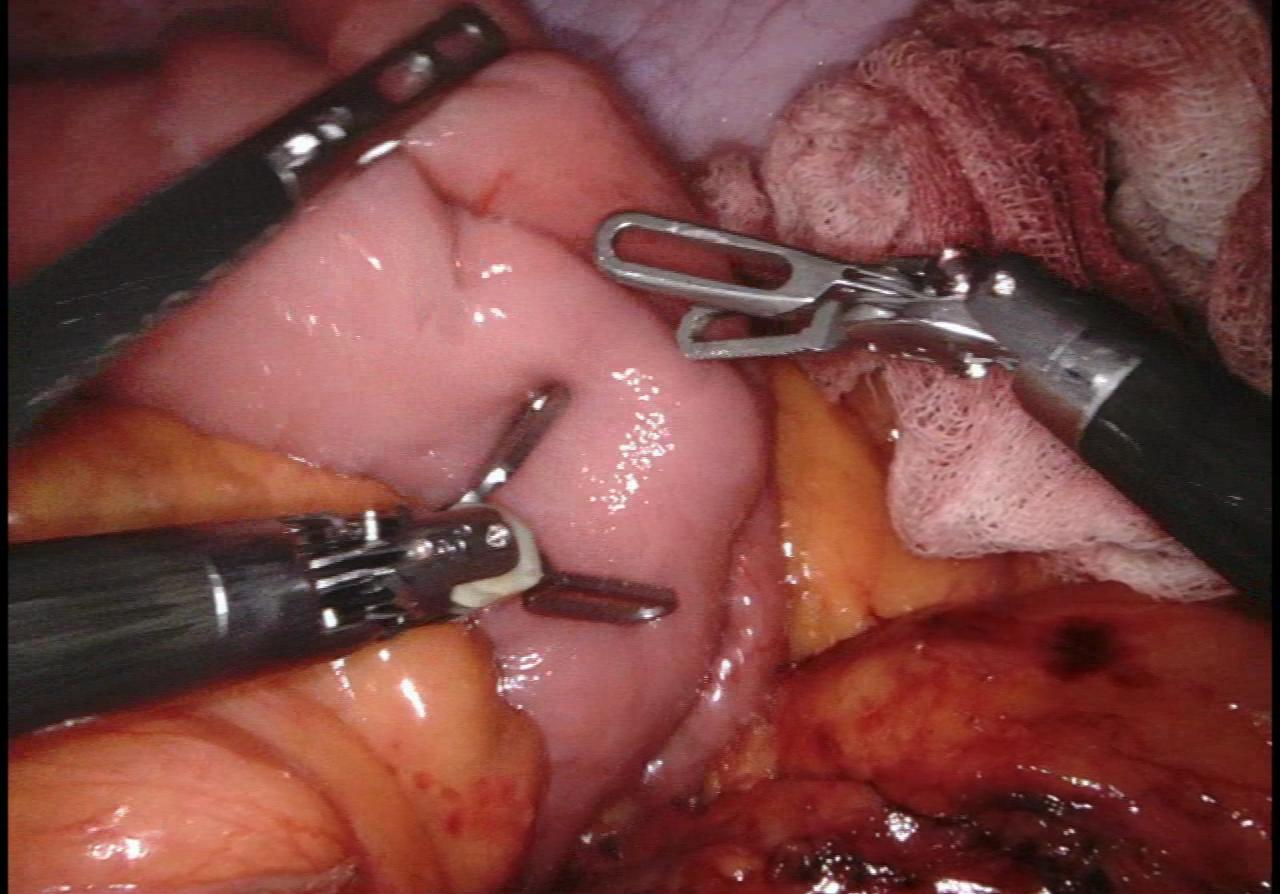

In [31]:
# # Get image of two cats chilling on couch
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
# image

# Instead get image from DSAD
image = Image.open(fp=r"C:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\DSAD4DeTr\test\images\1010700.jpg")
image

In [2]:
# Apply preprocessing to this image by using the DetrImageProcessor
# This will resize the image and normalise it across channels
from transformers import DetrImageProcessor
from config.config import get_cfg_defaults, combine_cfgs
import os, pathlib

# Get configs
config_path = 'config/Exps/DTxMSCL_DSAD.yaml'
config = combine_cfgs(config_path)

exp_path = pathlib.Path.cwd() / config.OUTPUT_LOG.path / config.OUTPUT_LOG.exp_tag
if not exp_path.exists():
        os.makedirs(exp_path)

# Define path to store the final model
if not (exp_path/"nets").exists():
        os.makedirs(exp_path/"nets")

print(exp_path)


# Select facebook trained or DTx config image processor

# processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
processor = DetrImageProcessor(do_normalize=config.DATA.normalize,
        size=config.DATA.resize_shortedge, max_size=config.DATA.resize_longedge,
        image_mean=config.DATA.image_mean, image_std=config.DATA.image_std)

encoding = processor(image, return_tensors="pt")
encoding.keys()
print(encoding['pixel_values'].shape)

c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\Model\DTx_SurgToolDetector_Dev\Results\DTxMsCL_DSAD


c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\transformers\models\detr\image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


NameError: name 'image' is not defined

In [ ]:
# Get the labels for the ground truth
labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

We will now conduct a forward pass, passing the pixel mask and values through the model.

In [26]:
# Load facebook or DSAD trained model
import os
import torch
from modeling.ModelTools import get_model
from tools import DETR_Wrapp
from transformers import DetrForObjectDetection

# model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

detector = get_model(config)
model = DETR_Wrapp(detector, config)
model_path = os.path.join('Models', 'job6665968.pt')
# model_path = os.path.join('Models', 'initial_test.pt')
model.model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([12]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Changing backbone config.
Adding Res2Net multiscale blocks
Using Res2Net res2net50_26w_4s
Adding connections for dense inference.
Used feature maps are [2, 3]


In [27]:
# Obtain the outputs of the model
import torch
from pprint import pprint

with torch.no_grad():
    outputs = model(**encoding)
    pprint(outputs.keys()) # The same outputs are given as in L0za007 model.

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


Let's visualise the results

In [28]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = {
        1: "abdominal_wall",
        2: "colon",
        3: "inferior_mesenteric_artery",
        4: "intestinal_veins",
        5: "liver",
        6: "pancreas",
        7: "small_intestine",
        8: "spleen",
        9: "stomach",
        10: "ureter",
        11: "vesicular_glands"
    }

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(8,5)) # Creates figure of this size
    plt.imshow(pil_img) # Loads image
    ax = plt.gca() # Gets the current axes
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        # text = f'{model.config.id2label[label]}: {score:0.2f}'
        text = f'{CLASSES[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# Create a ground truth plotting function
def plot_ground_truth(pil_img, labels, boxes):
    

In [32]:
# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.02)
pprint(postprocessed_outputs)
results = postprocessed_outputs[0]

[{'boxes': tensor([[301.7236, 272.6651, 696.2188, 538.4691],
        [301.8781, 272.5660, 696.0214, 538.1107],
        [301.5531, 272.6632, 695.6134, 538.3779],
        [302.2219, 272.4707, 696.6279, 538.1123],
        [302.0643, 272.4501, 696.1771, 538.0986],
        [301.9469, 272.6868, 696.2996, 538.3319],
        [301.6952, 272.6357, 695.8566, 538.2311],
        [301.3767, 272.6283, 695.3203, 538.2053],
        [301.8691, 272.4741, 695.7254, 538.0663],
        [301.6631, 272.3946, 695.7435, 538.1554],
        [302.2757, 272.7404, 696.5564, 538.3942],
        [301.2349, 272.6516, 695.5037, 538.4869],
        [302.0541, 272.5610, 696.7693, 538.4282],
        [302.2906, 272.6621, 696.7123, 538.4290],
        [302.4054, 272.6935, 696.9528, 538.4720],
        [301.5187, 272.4694, 695.6846, 538.1908],
        [301.6837, 272.4664, 695.4854, 538.0781],
        [302.7267, 272.4772, 697.2739, 538.1348],
        [302.1538, 272.6680, 696.6252, 538.3795],
        [301.9127, 272.6270, 696.4324, 

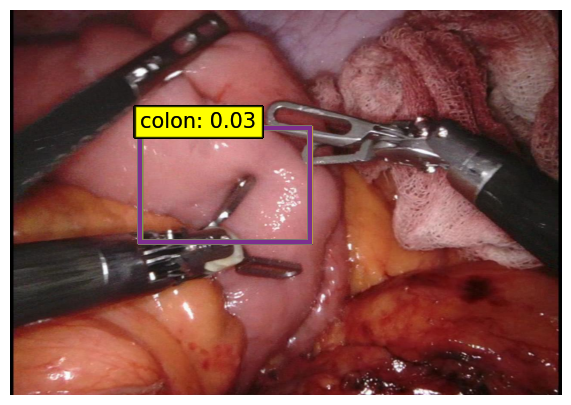

In [33]:
plot_results(image, results['scores'], results['labels'], results['boxes'])